<img src="logo3.jpg" style="float:left; max-width: 150px; margin-right: 20px;">
<div style="clear:left; text-align:center; font-family: Didot, serif;">
    <h1 style="font-size:25px;">Université Toulouse III - Paul Sabatier</h1>
    <p style="text-align:center; font-size:25px;">UE: Calcul scientifique et apprentissage automatique</p>
    <p style="text-align:center; font-size:20px;">Master 1 IAFA</p>
    <p style="font-size:20px;">Réalisé par : Nouh Chelgham et Noura Faiz </p>
</div>

# Mini-Projet :  Détection de sons de Beatbox

<span style="font-family: Arial"><h2 style="font-family: Didot, serif;">Objectif</h2></span>

L'objectif de ce TP consiste à détecter et reconnaître les différents sons de beatbox à partir de fichiers sonores au format *.wav* via l'analyse cepstrale.


<img src="./Sons_Beatbox.png" width="800">



Nous disposons d'une base d'enregistrements de beatbox. Il faut reconnaître les 12 sons beatbox suivants :

$$\text{'cymbale_expiree', 'cymbale_inspiree', 'hihat_humming', 'hihat_power ferme', 'hihat_power ouvert', 'kick_humming', }$$
$$\text{'kick_power','rimshot_humming', 'rimshot_power', 'snare_humming', 'snare_power', 'snare_power inverse'}$$


**Source :** https://pubs.aip.org/asa/jasa/article/149/1/191/610401 \
Paroni, Annalisa, et al. *Vocal drum sounds in human beatboxing: An acoustic and articulatory exploration using electromagnetic articulography.* The Journal of the Acoustical Society of America 149.1 (2021): 191-206.


<h2 style="font-family: Didot, serif;">1. Préparation des données</h2></span>

In [2]:

# Importations nécessaires pour l'analyse et la visualisation de données
import matplotlib.pyplot as plt  # Pour les graphiques
import numpy as np               # Calculs et manipulations de tableaux
import scipy                     # Outils de calcul scientifique
import sklearn                   # Bibliothèque d'apprentissage automatique

# Outils spécifiques pour l'apprentissage automatique
from sklearn.neighbors import KNeighborsClassifier  # Algorithme KNN pour la classification
from sklearn.cluster import KMeans                  # Algorithme KMeans pour le clustering
from sklearn.model_selection import train_test_split

# Fonctions mathématiques et évaluation des modèles
import math
from sklearn.metrics import accuracy_score          # Évaluer la précision d'un modèle
from sklearn.metrics import confusion_matrix        # Matrice de confusion pour la performance

# Amélioration des visualisations avec seaborn
import seaborn as sns  # Graphiques améliorés basés sur matplotlib


<h3 style="color:#00008B; font-family: Didot, serif;">1.1. Chargement des données </h3>


Nous utilisons un ensemble de données obtenu à partir de la conversion d'enregistrements audio en matrices de paramètres. Ces paramètres, nommés MFCC (Mel Frequency Cepstral Coefficient), sont cruciaux pour l'analyse du contenu vocal fréquenciel des signaux audio.

La conversion a été effectuée en utilisant la bibliothèque **librosa**, largement reconnue dans le traitement audio avec Python.

Chaque enregistrement audio est représenté par un vecteur ligne dans notre matrice de données. La dimension de ce vecteur est fixe, égale à 13, qui correspond au nombre moyen de coefficients MFCC représentatifs. Par conséquent, notre matrice possède autant de lignes qu'il y a d'enregistrements audio, et 13 colonnes correspondant aux coefficients MFCC.








In [3]:

# Chargement des données à partir d'un fichier matlab .mat
import scipy.io as sio
from google.colab import files

uploaded = files.upload()
test = sio.loadmat('2016HBXX_effets_mfcc_nodeltas_XY_nozcaPerFile_zcaX.mat')


# data = matrice des données : nombre d'enregistrements x 13 coefficients
data=test['X']
data=np.array(data)
data=data.astype('float64')
print('Dimension de la matrice des MFCC :',data.shape)

# label = Numéro correspondant à un son de beatbox associé à chaque enregistrement
label=test['Y']
label=np.ravel(label)
print('Dimension des labels', label.shape)

# liste des sons de beatbox
Nomlabel=['cymbale_expiree', 'cymbale_inspiree', 'hihat_humming', 'hihat_power ferme', 'hihat_power ouvert', 'kick_humming','kick_power','rimshot_humming', 'rimshot_power', 'snare_humming', 'snare_power', 'snare_power inverse']

data


Saving 2016HBXX_effets_mfcc_nodeltas_XY_nozcaPerFile_zcaX.mat to 2016HBXX_effets_mfcc_nodeltas_XY_nozcaPerFile_zcaX.mat
Dimension de la matrice des MFCC : (341, 13)
Dimension des labels (341,)


array([[ 1.08949   , -0.539287  ,  0.639512  , ...,  0.265867  ,
        -0.20644   ,  0.00914672],
       [ 1.58669   , -0.18074   , -0.187801  , ...,  0.143895  ,
         0.208489  ,  0.0161633 ],
       [ 0.723022  , -0.167298  ,  0.0842389 , ...,  0.343518  ,
         0.211322  ,  0.0170742 ],
       ...,
       [ 0.605994  , -0.547368  , -1.67372   , ...,  0.166655  ,
         0.594501  , -0.574815  ],
       [-0.665185  , -0.442276  , -1.92715   , ...,  0.151776  ,
         0.179048  , -0.694647  ],
       [ 1.67444   , -1.01833   , -1.338     , ..., -0.144372  ,
         0.394216  , -1.05926   ]])

<h3 style="color:#00008B; font-family: Didot, serif;">1.2. Description du jeu de données  </h3>

In [4]:
# Récupération des labels uniques et de leurs fréquences d'occurrence
unique, counts = np.unique(label, return_counts=True)

"""" Affichage de chaque label, son nom correspondant
et son nombre d'enregistrements"""

for i in range(unique.shape[0]):
    print('Label',unique[i],'correspond à ',Nomlabel[i],':',counts[i],'enregistrements');


Label 0 correspond à  cymbale_expiree : 28 enregistrements
Label 1 correspond à  cymbale_inspiree : 18 enregistrements
Label 2 correspond à  hihat_humming : 37 enregistrements
Label 3 correspond à  hihat_power ferme : 20 enregistrements
Label 4 correspond à  hihat_power ouvert : 24 enregistrements
Label 5 correspond à  kick_humming : 37 enregistrements
Label 6 correspond à  kick_power : 42 enregistrements
Label 7 correspond à  rimshot_humming : 25 enregistrements
Label 8 correspond à  rimshot_power : 38 enregistrements
Label 9 correspond à  snare_humming : 30 enregistrements
Label 10 correspond à  snare_power : 22 enregistrements
Label 11 correspond à  snare_power inverse : 20 enregistrements


<h3 style="color:#00008B; font-family: Didot, serif;">1.3. Découpage de l'ensemble de données en Apprentissage et test pour les approches supevisée  </h3>

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.33, random_state=42)

La fonction **train_test_split** de Scikit-learn a été employée afin de fractionner notre ensemble de données et ses étiquettes associées en deux sous-ensembles distincts : un pour l'entraînement et l'autre pour le test.<br>
La paramétrisation avec **test_size**=0.33 garantit que 33% de l'ensemble initial sera réservé pour le test, laissant ainsi les 67% restants destinés à l'entraînement. De plus, afin d'assurer la cohérence et la reproductibilité de nos divisions à travers différentes exécutions, le paramètre **random_state** a été fixé à 42.

<h2 style="font-family: Didot, serif;">2. Fonctions pour réaliser une table de correspondance entre le label des approches non supervisées et le label réel</h2></span>

<h3 style="color:#00008B; font-family: Didot, serif;">2.1. Fonction 'retrieve_info' </h3>

La fonction **retrieve_info** a été conçue pour attribuer à chaque cluster l'étiquette qui y est le plus fréquemment observée. Dans le contexte du clustering non supervisé, les étiquettes générées par l'algorithme peuvent être arbitraires et ne pas coïncider avec les véritables étiquettes des données. Ainsi, cette fonction s'avère cruciale pour ajuster ces étiquettes de clusters en fonction des étiquettes réelles prédominantes au sein de chaque groupe.

In [6]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

<h3 style="color:#00008B; font-family: Didot, serif;">2.1. Fonction 'correspondance' </h3>

La fonction **correspondance** vise à aligner les étiquettes prédites par un algorithme de clustering avec les étiquettes réelles de l'ensemble d'entraînement. Elle s'appuie sur la fonction **retrieve_info** pour déterminer les étiquettes réelles dominantes associées à chaque cluster. Ensuite, elle ajuste les étiquettes prédites en fonction de cette correspondance.

In [7]:
def correspondance(y_pred_kmeans,y_train):
  # Correspondance entre la partition et les classes de la vérité terrain
  reference_labels = retrieve_info(y_pred_kmeans,y_train)
  number_labels = np.zeros(len(y_pred_kmeans))
  for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[y_pred_kmeans[i]]
  return number_labels

<h2 style="font-family: Didot, serif;">3. Classification sans prétraitement </h2></span>
<h3 style="color:#00008B; font-family: Didot, serif;">3.1. Méthode supervisée (KNN : k nearest neighbors) : </h3>

### A. Algorithme


Le KNN est un algorithme de classification supervisé. Pour chaque observation $x_{i}=(x^{1}_{i}, x^{1}_{i}, x^{2}_{i}, ... x^{n}_{i}) $ , nous avons une étiquette associée $y_{i}$, qui représente la classe de $x_{i}$.

Pour classer un nouveau vecteur \( x \) à l'aide de KNN :

1. Calculez la distance (souvent euclidienne, mais d'autres métriques peuvent être utilisées) entre x  et chaque échantillon  $x_{i}$ dans l'ensemble d'entraînement.
2. Identifiez les k  échantillons  $x_{i}$ les plus proches de x .
3. La classe attribuée à x  sera celle qui est majoritairement représentée parmi ces k  voisins les plus proches.

<img src="data.png" style="float:center;">

In [8]:
accuracys=[]
cms=[]
for i in range (1 , 13 , 2) :
    neight = KNeighborsClassifier(n_neighbors=i)
    neight.fit(X_train , y_train)
    y_pred=neight.predict(X_test)
    accuracys.append(accuracy_score(y_test , y_pred))
    cms.append(confusion_matrix(y_test , y_pred))


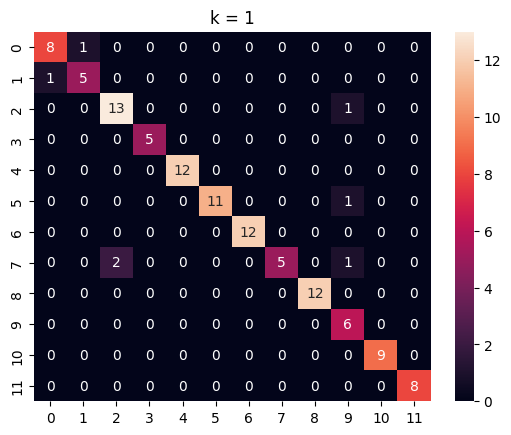

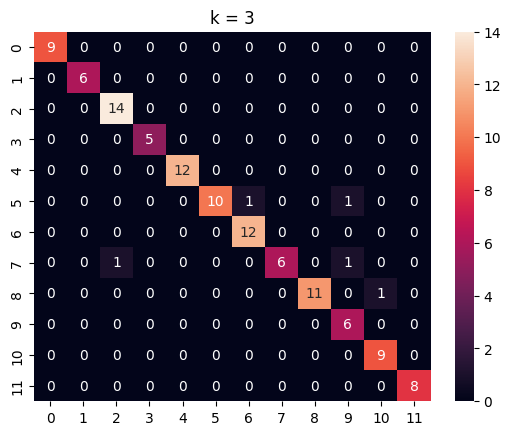

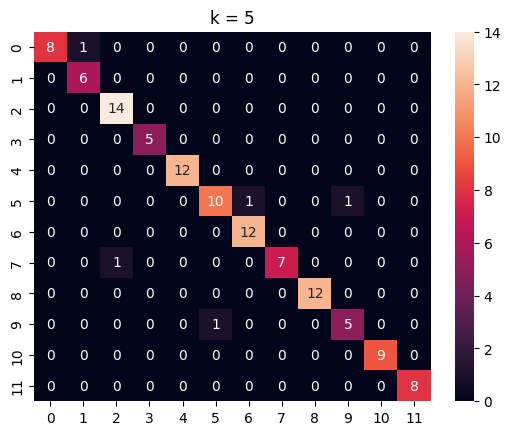

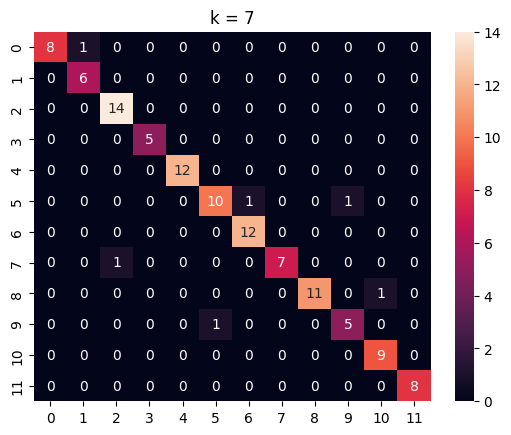

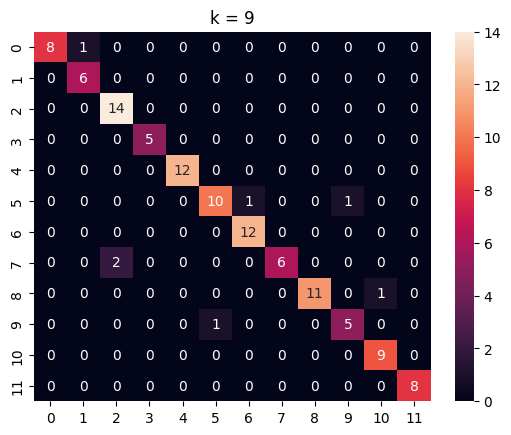

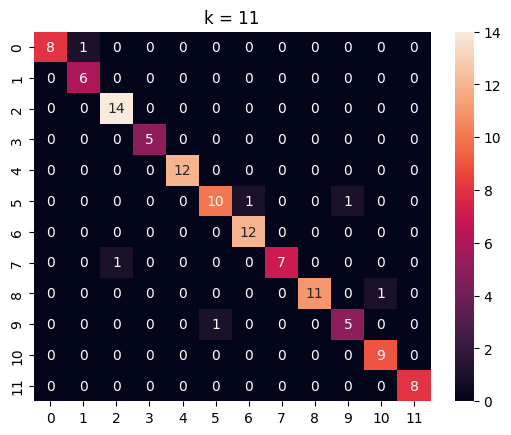

In [9]:
#plot confusion matrix
for i in range(len(cms)):
    plt.title("k = "+str(i+(i+1%2)))
    sns.heatmap(cms[i],annot=True,fmt="d")
    plt.show()

In [10]:
#accuracy for each value of k
K = {}
for i in range(len(accuracys)):
    K[ i+(i+1%2) ] = accuracys[i]
    print("k = {} \t | \t accuracy = {}".format(str(i+(i+1%2)),accuracys[i]))
print(K)

k = 1 	 | 	 accuracy = 0.9380530973451328
k = 3 	 | 	 accuracy = 0.9557522123893806
k = 5 	 | 	 accuracy = 0.9557522123893806
k = 7 	 | 	 accuracy = 0.9469026548672567
k = 9 	 | 	 accuracy = 0.9380530973451328
k = 11 	 | 	 accuracy = 0.9469026548672567
{1: 0.9380530973451328, 3: 0.9557522123893806, 5: 0.9557522123893806, 7: 0.9469026548672567, 9: 0.9380530973451328, 11: 0.9469026548672567}


Trace la precision de ce modele en fonction de k. quel valeur de k choisir pour ce problème?

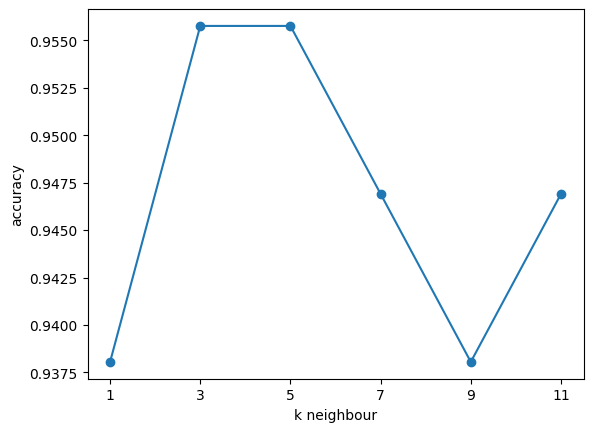

In [11]:
#plot section
plt.plot(np.arange(1,13,2),np.array(accuracys),marker="o")
plt.xticks(np.arange(1, 13,2))
plt.xlabel('k neighbour')
plt.ylabel('accuracy')
plt.show()


In [12]:
def get_max_K(K):
    max_value = max(K.values())
    max_keys = [k for k, v in K.items() if v == max_value]
    return max_keys[0]

print("la valeur optimale de k pour ce probleme est: ",get_max_K(K))

la valeur optimale de k pour ce probleme est:  3


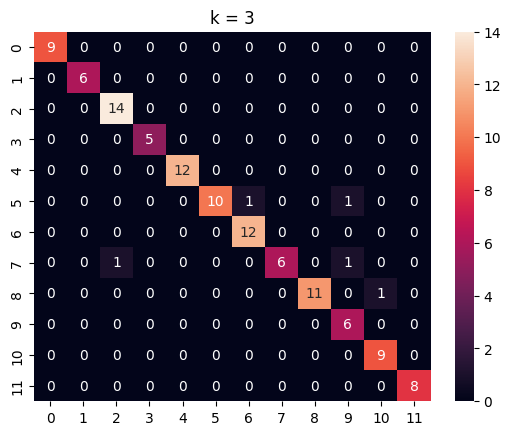

0.9557522123893806

In [13]:
plt.title("k = 3")
sns.heatmap(cms[1],annot=True,fmt="d")
plt.show()
accuracys[2]

## Méthode non supervisée
Indiquer quelle est la méthode non supervisée de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 
 Matrice de confusion :



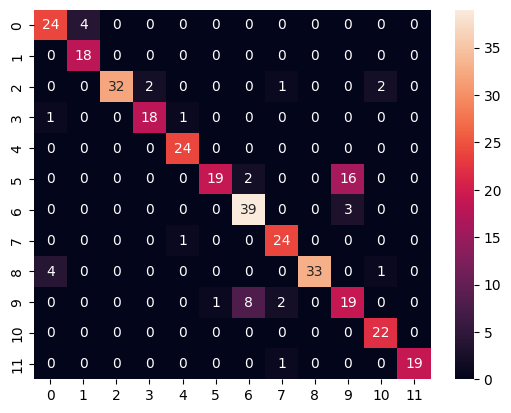


Score de précision : 0.8533724340175953


In [14]:
#Initialiser et exécuter K-means

# On fixe le nombre de clusters au nombre d'étiquettes uniques dans notre ensemble de données
n_clusters = len(unique)
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

#ajuster le modèle et obtenir les clusters
y_pred = kmeans.fit_predict(data)

#obtenir une correspondance entre les clusters de K-means et les véritables étiquettes
y_pred_label = correspondance(y_pred, label)

# Calcul de la matrice de confusion
cm = confusion_matrix(label, y_pred_label)

# Calcul du score de précision
accuracy = accuracy_score(label, y_pred_label)

print(" \n Matrice de confusion :\n")

sns.heatmap(cm,annot=True,fmt="d")
plt.show()

print("\nScore de précision :", accuracy)


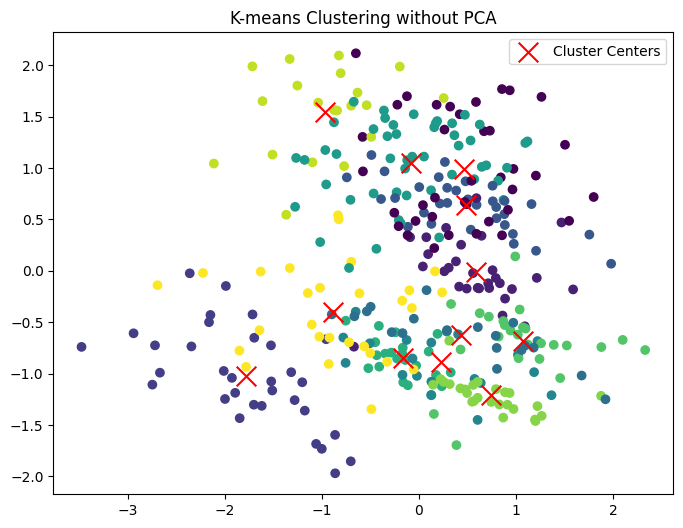

In [15]:
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200, label='Cluster Centers')
plt.title('K-means Clustering without PCA')
plt.legend()
plt.show()

# Partie II : Classification des sons beatbox avec prétraitement


## Méthode supervisée avec réduction de dimension par ACP sur l'ensemble d'apprentissage
Réaliser une ACP sur l'ensemble d'apprentissage pour réduire la dimension, visualiser les données
puis projeter les données de l'ensemble de test dans la base de l'ACP.

Indiquer quelle est la méthode supervisée de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

# K-NN ACP

In [16]:
from sklearn.decomposition import PCA

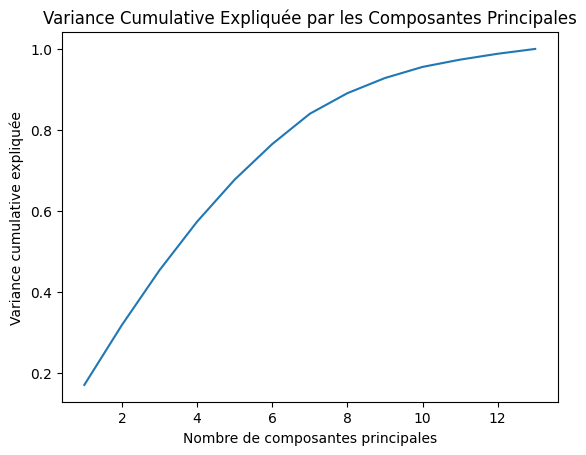

In [17]:
num_components = 13
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_

# Variance totale
total_variance = np.sum(explained_variance)

# Proportion de variance expliquée par chaque composante
explained_variance_ratio = explained_variance / total_variance

# Créer un graphique de la variance cumulative
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.title("Variance Cumulative Expliquée par les Composantes Principales")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance cumulative expliquée")
plt.show()

In [18]:
num_components = 12 # on prend 12 mais 10 aussi est faisable
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

accuracies=[]
cm=[]
for i in range (1 , 13 , 2) :
    neight = KNeighborsClassifier(n_neighbors=i)
    neight.fit(X_train_pca , y_train)
    y_pred=neight.predict(X_test_pca)
    accuracies.append(accuracy_score(y_test , y_pred))
    cm.append(confusion_matrix(y_test , y_pred))


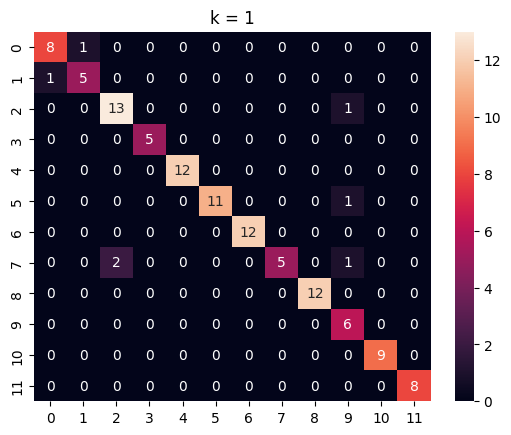

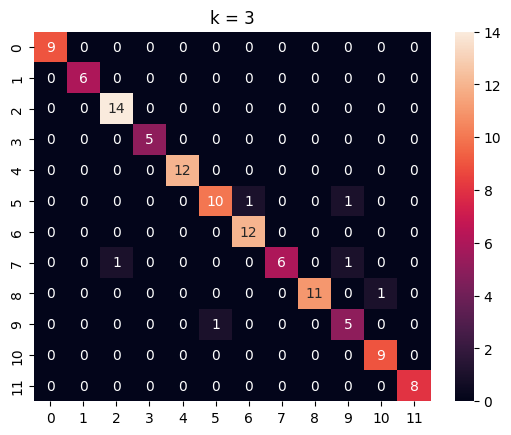

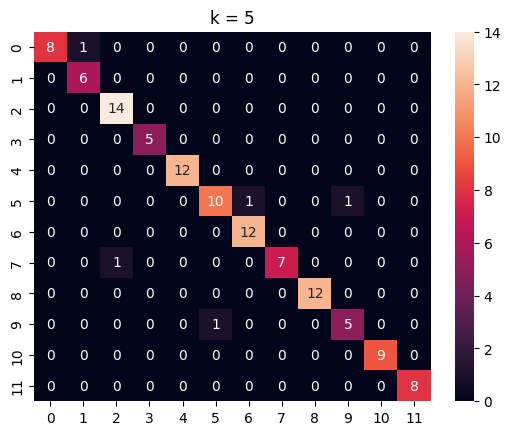

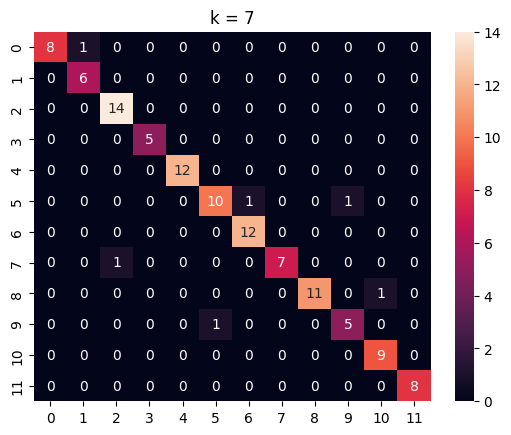

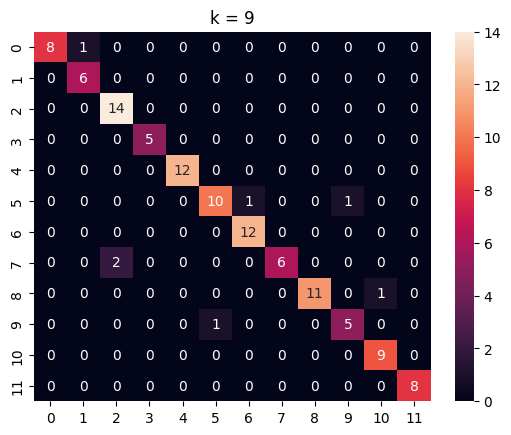

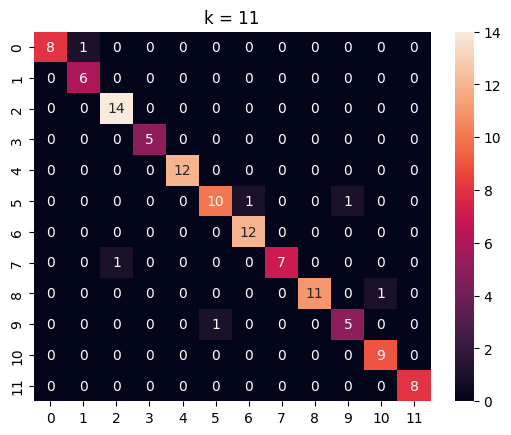

In [19]:
for i in range(len(cm)):
    plt.title("k = "+str(i+(i+1%2)))
    sns.heatmap(cm[i],annot=True,fmt="d")
    plt.show()

In [20]:
K = {}
for i in range(len(accuracies)):

    K[ i+(i+1%2) ] = accuracies[i]
    print("k = {} \t | \t accuracy = {}".format(str(i+(i+1%2)),accuracies[i]))
print(K)

k = 1 	 | 	 accuracy = 0.9380530973451328
k = 3 	 | 	 accuracy = 0.9469026548672567
k = 5 	 | 	 accuracy = 0.9557522123893806
k = 7 	 | 	 accuracy = 0.9469026548672567
k = 9 	 | 	 accuracy = 0.9380530973451328
k = 11 	 | 	 accuracy = 0.9469026548672567
{1: 0.9380530973451328, 3: 0.9469026548672567, 5: 0.9557522123893806, 7: 0.9469026548672567, 9: 0.9380530973451328, 11: 0.9469026548672567}


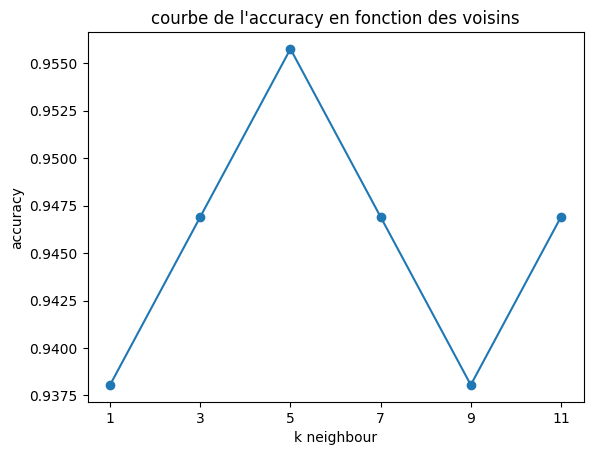

In [21]:
plt.plot(np.arange(1,13 , 2),np.array(accuracies),marker="o")
plt.xticks(np.arange(1, 13 , 2))
plt.title("courbe de l'accuracy en fonction des voisins")
plt.xlabel('k neighbour')
plt.ylabel('accuracy')
plt.show()

In [22]:
def get_max_K(K):
    max_value = max(K.values())
    max_keys = [k for k, v in K.items() if v == max_value]
    return max_keys[0]

print("la valeur optimale de k pour ce probleme est: ",get_max_K(K))

la valeur optimale de k pour ce probleme est:  5


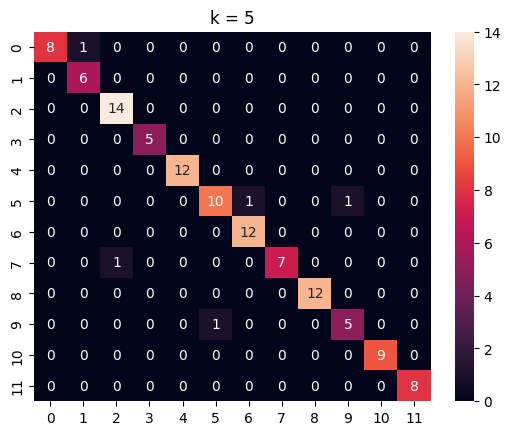

0.9557522123893806

In [23]:
plt.title("k = 5")
sns.heatmap(cm[2],annot=True,fmt="d")
plt.show()
accuracies[2]


## Méthode non supervisée avec réduction de dimension par ACP sur l'ensemble des données

Réaliser une ACP sur l'ensemble des données et indiquer quelle est la méthode supervisée de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

# K-MEANS ACP

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(data)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

[4433.000000000002, 3975.4396084043883, 3576.1811606266774, 3271.989517803466, 2959.5115055769857, 2712.6255431933405, 2560.141641106567, 2359.306911393778, 2183.3741171131605, 2030.7924779547739, 1919.208961152445, 1816.0605463241404]


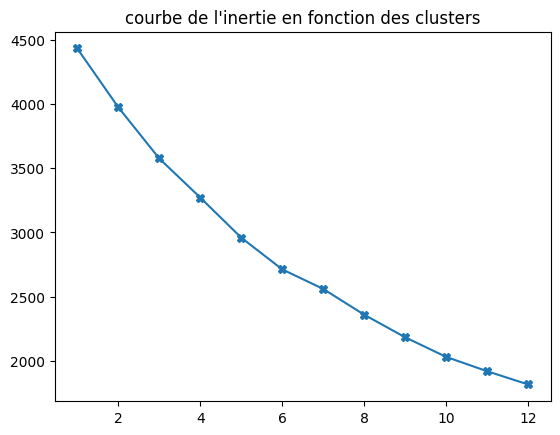

In [25]:
inertie=[]
for c in  range (1, 13):
  kmeans = KMeans (init = 'k-means++' , n_clusters=c)
  kmeans.fit(x_scaled)
  inertie.append(kmeans.inertia_)
print (inertie)
plt.figure()
plt.plot(range(1,13) , inertie,marker='X')
plt.title("courbe de l'inertie en fonction des clusters")
plt.show()

# pas evident vu que y'a pas de cassures nettes dans ce graphe

Matrice de confusion :


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


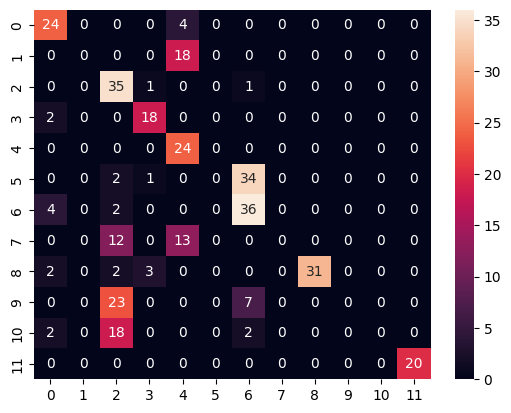


Score de précision : 0.5513196480938416


In [26]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Réduction de dimension avec PCA
n_components = 7# Nombre de composantes principales à conserver à partir de la courbe
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(x_scaled)

kmeans = KMeans(n_clusters=7, random_state=0)
y_pred = kmeans.fit_predict(data_pca)
y_pred_label = correspondance(y_pred, label)

# Calcul de la matrice de confusion
cm = confusion_matrix(label, y_pred_label)

# Calcul du score de précision
accuracy = accuracy_score(label, y_pred_label)

print("Matrice de confusion :")
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

print("\nScore de précision :", accuracy)

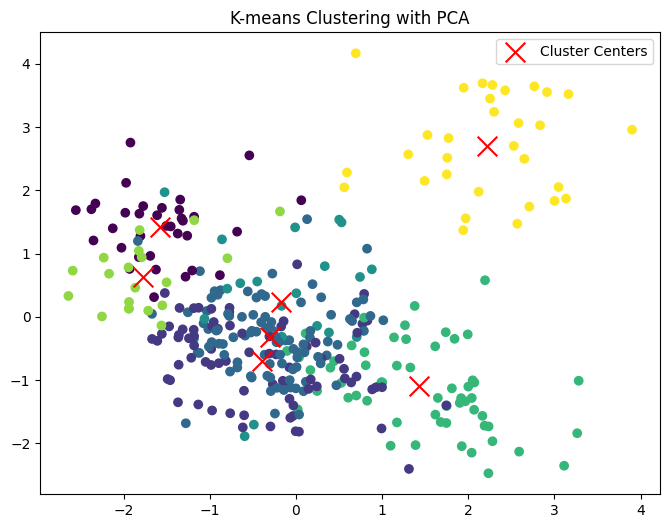

In [27]:
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200, label='Cluster Centers')
plt.title('K-means Clustering with PCA')
plt.legend()
plt.show()

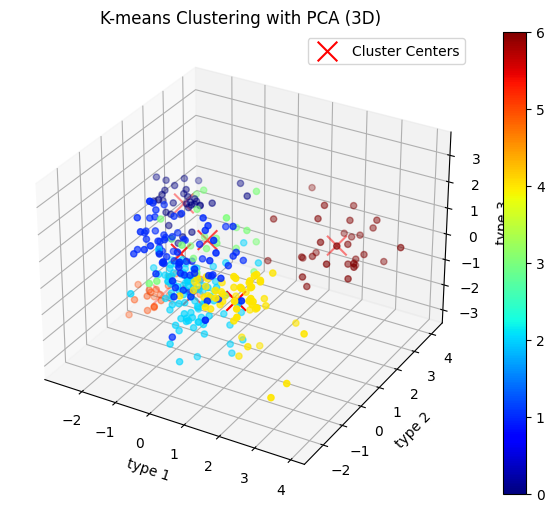

In [28]:

# 3D Scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=kmeans.labels_, cmap='jet')

# Plot cluster centers in 3D
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], c='red', marker='x', s=200, label='Cluster Centers')
plt.title('K-means Clustering with PCA (3D)')
ax.set_xlabel("type 1")
ax.set_ylabel("type 2")
ax.set_zlabel("type 3")
plt.legend()
plt.colorbar(scatter)

plt.show()

# Partie III : Votre analyse


Pour chaque résultat obtenu, calculer la matrice de confusion et utiliser l'article et les signaux présentés ci-dessus pour interpréter les résultats.

Un rapport de maximum 10 pages sera à rendre avec le notebook des codes ayant donné ces résultats.